# Settings and imports

#### Imports

In [2]:
# Basic built-in
import os

# Third-party for data (general)
import numpy as np
import pandas as pd

# Third-party for plots
import matplotlib.pyplot as plt
import seaborn as sns
import upsetplot

from matplotlib.colors import LogNorm

# Third party for omics- data
import bbi # ChIP-seq signal processing
import bioframe as bf # Genomic intervals operations
import cooler # Hi-C data processing
import cooltools # Hi-C data processing

# Third-party utils
from tqdm import tqdm

# Custom
from my_polycomb_utils.my_hic_maps_polycomb_utils import impute_nans

#### Preparing font

In [ ]:
! mkdir fonts

! wget https://github.com/webfontworld/Montserrat/raw/main/Montserrat-Regular.ttf
! wget https://github.com/webfontworld/Montserrat/raw/main/Montserrat-Black.ttf
! wget https://github.com/webfontworld/Montserrat/raw/main/Montserrat-Bold.ttf
! wget https://github.com/webfontworld/Montserrat/raw/main/Montserrat-Italic.ttf
    
! mv Montserrat-Regular.ttf fonts
! mv Montserrat-Black.ttf fonts
! mv Montserrat-Bold.ttf fonts
! mv Montserrat-Italic.ttf fonts

In [3]:
from pathlib import Path
from matplotlib import font_manager

fpath=Path("./fonts/Montserrat-Regular.ttf")
fe = font_manager.FontEntry(fname=fpath, name='Montserrat')
font_manager.fontManager.ttflist.insert(0, fe) # or append is fine
font_manager.fontManager.addfont(fpath)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Montserrat']

#### Settings

In [4]:
# Set-up suppression of some varnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Set-up suppression of some logging
import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('fontTools').setLevel(logging.WARNING)

# 01: HiC map bird-eye view

**Figures in thesis:**
- `Figure 2`

In [5]:
# Load Hi-C data
RES = 150000
clr_plus = cooler.Cooler(f'data/hc_plus.mcool::/resolutions/{RES}/')
clr_minus = cooler.Cooler(f'data/hc_minus.mcool::/resolutions/{RES}/')
chroms_view = pd.DataFrame(data={
                                 'chrom': clr_plus.chromsizes.index,
                                 'start': [0] * len(clr_plus.chromsizes),
                                 'end': clr_plus.chromsizes.values,
                                 'name': clr_plus.chromsizes.index
})

# Select the region to visualize
start, end = 80_000_000, 140_000_000
region = ('chr6', start, end)
mtr_plus = (clr_plus.matrix(balance=True).fetch(region)[:])
mtr_minus = (clr_minus.matrix(balance=True).fetch(region)[:])

# Make combined matrix 
# with hc_plus as upper-right part
# and hc_minus as lower-left part
combined = np.zeros_like(mtr_plus)
combined[np.triu_indices_from(combined)] = mtr_plus[np.triu_indices_from(mtr_plus)]
combined[np.tril_indices_from(combined)] = mtr_minus[np.tril_indices_from(mtr_minus)]

# Impute some NaNs (only for better visualization!)
combined = impute_nans(combined)

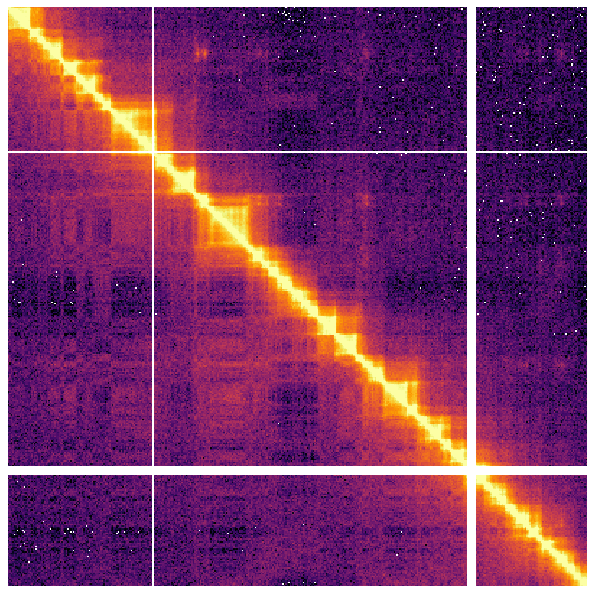

In [6]:
fig, ax = plt.subplots(figsize=(8,8), dpi=80)

norm = LogNorm(vmax=0.02, vmin=0.0001)
cmap = 'inferno'
im = ax.matshow(combined,
                norm=norm, 
                cmap=cmap,
                extent=(start, end, end, start)
               )
plt.tight_layout()
plt.axis('off');

# 02: Polycomb loops Anchors

**Figures in thesis:**
- `Figure 3`: (I) Average anchor, (II) H3K27me3 ChIP-seq signal, (III) ChromHMM annotation

In [7]:
polycomb_anchors = pd.read_table('data/polycomb_dot_anchors.hand_made.bed', 
                          names=['chrom', 'start', 'end', 'genes'], na_values='-')

### _02 (I) Average anchor

In [8]:
RES = 20000
clr_plus = cooler.Cooler(f'data/hc_plus.mcool::/resolutions/{RES}/')
clr_minus = cooler.Cooler(f'data/hc_minus.mcool::/resolutions/{RES}/')

chroms_view = pd.DataFrame(data={
                                 'chrom': clr_plus.chromsizes.index,
                                 'start': [0] * len(clr_plus.chromsizes),
                                 'end': clr_plus.chromsizes.values,
                                 'name': clr_plus.chromsizes.index
})

clrs = {'NeuN+': clr_plus,
        'NeuN-': clr_minus,
}

In [9]:
# Calculate excpected Hi-C map for plus and minus samples
cvds = {}
for sample in tqdm(clrs.keys()):
    cvds[sample] = cooltools.expected_cis(clrs[sample],
                                          view_df = chroms_view,
                                          smooth = False,
                                          nproc = 6
                                          )

100%|██████████| 2/2 [00:28<00:00, 14.21s/it]


In [10]:
# Calculate pileups (average features)
flank=300000

pileups = {}
for sample in tqdm(clrs.keys()):
    stack = cooltools.pileup(clrs[sample], polycomb_anchors, 
                             expected_df = cvds[sample],
                             view_df = chroms_view, flank = flank,
                             nproc = 6,
                             )

    pileup = np.nanmean(stack, axis=2)
    pileups[sample] = pileup

100%|██████████| 2/2 [00:08<00:00,  4.46s/it]


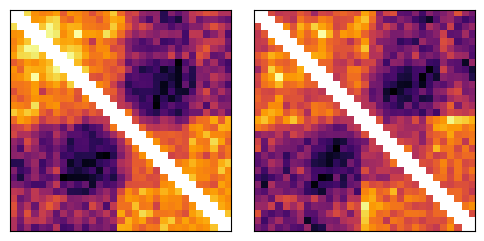

In [11]:
fig, axs = plt.subplots(figsize=(6, 3), ncols=2,
                       dpi=100)
plt.subplots_adjust(wspace=.1)

to_add_ticks_labels = False

for ax, sample in zip(axs, clrs.keys()):
    ax.imshow(np.log2(pileups[sample]),
               cmap = 'inferno',
               interpolation = 'none',
              )

    if to_add_ticks_labels:
        ticks_pixels = np.linspace(0, flank*2//RES,5)
        ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*RES//1000).astype(int)
        ax.set_xticks(ticks_pixels, ticks_kbp)
        ax.set_yticks(ticks_pixels, ticks_kbp)
        ax.set_xlabel('relative position, kbp')
        ax.set_ylabel('relative position, kbp')
    else:
        ax.set_xticks([]), ax.set_yticks([])

### _02 (II) H3K27me3 ChIP-seq signal

In [12]:
polycomb_anchors_100kb = polycomb_anchors[(polycomb_anchors.end - polycomb_anchors.start) == 10000]

flank = 50000 # Length of flank to one side from the boundary, in basepairs
nbins = 100   # Number of bins to split the region

chroms, starts, ends = (polycomb_anchors_100kb.chrom,
                        polycomb_anchors_100kb.start-flank,
                        polycomb_anchors_100kb.end+flank
                       )
                        
stackup_plus = bbi.stackup('data/H3K27me3_Neuron.bw', chroms, starts, ends, bins=nbins)
stackup_minus = bbi.stackup('data/H3K27me3_NonNeuron.bw', chroms, starts, ends, bins=nbins)

stackups = {'NeuN+': stackup_plus,
            'NeuN-': stackup_minus,
    }

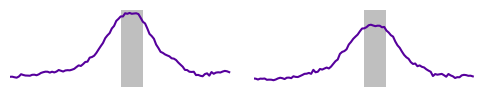

In [13]:
fig, axs = plt.subplots(figsize=(6, 1), ncols=2,
                       dpi=100)
plt.subplots_adjust(wspace=.1)

for ax, sample in zip(axs, clrs.keys()):

    ax.plot(np.nanmean(stackups[sample], axis=0), color='#56009c' )
    ax.axvspan(xmin = nbins//2, 
               xmax = nbins//2+10000//(2*flank/nbins), 
               facecolor='grey', alpha=0.5)
    
    ax.set(xticks = np.arange(0, nbins+1, 20),
           xticklabels = (np.arange(0, nbins+1, 20)-nbins//2)*flank*2/nbins/1000,
           xlabel = 'Distance from boundary, kbp',
           ylabel = 'H3K27M3 signal');

    ax.set_xlim(0, 100)
    ax.set_ylim(0, 4)
    ax.set_axis_off() # removes all ticks and labels

### _02 (III) ChromHMM annotation

In [14]:
def get_anchor_type(xs):
    xs = sorted(list(set(xs)))
    return [x for x in xs if x is not None]
    return '-'.join([x for x in xs if x is not None])

In [15]:
# Get ChromHMM mark-up
chromatin_states = pd.read_csv('https://www.encodeproject.org/files/ENCFF266IIT/@@download/ENCFF266IIT.bed.gz', sep = "\t", header = None)
chromatin_states = chromatin_states.loc[:,[0,1,2,3]]
chromatin_states.columns = ['chrom', 'start', 'end', 'state']

# Assing ChromHMM states to Polycomb anchors
polycomb_anchors_annohmm = bf.overlap(polycomb_anchors, chromatin_states, how='left', suffixes=('','_anno'))
polycomb_anchors_annohmm = polycomb_anchors_annohmm.groupby(['chrom', 'start', 'end']).agg({'state_anno': get_anchor_type}).reset_index()
annotypes = chromatin_states.state.unique().tolist()
for annotype in annotypes:
    polycomb_anchors_annohmm[annotype] = polycomb_anchors_annohmm['state_anno'].apply(lambda x: annotype  in x)

In [16]:
# Filter ChromHMM states for the plot
upset_table = polycomb_anchors_annohmm[annotypes + ['chrom', 'start', 'end']].groupby(annotypes).size()
upset_table = upset_table[upset_table>3].reset_index()
upset_table = upset_table.loc[:,upset_table.any(axis=0)]
upset_table = upset_table.set_index(list(set(upset_table.columns) - (set(annotypes)-set(upset_table.columns)) - set([0])))

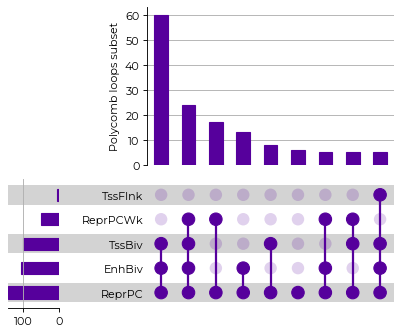

In [17]:
fig = plt.figure(figsize=(3, 2), dpi=80)
ax_dict = upsetplot.UpSet(upset_table[0],
                          sort_by="cardinality", 
                          facecolor="#56009c", 
                          shading_color="lightgray"
                         ).plot(fig=fig)

ax_dict["intersections"].set_ylabel("Polycomb loops subset");

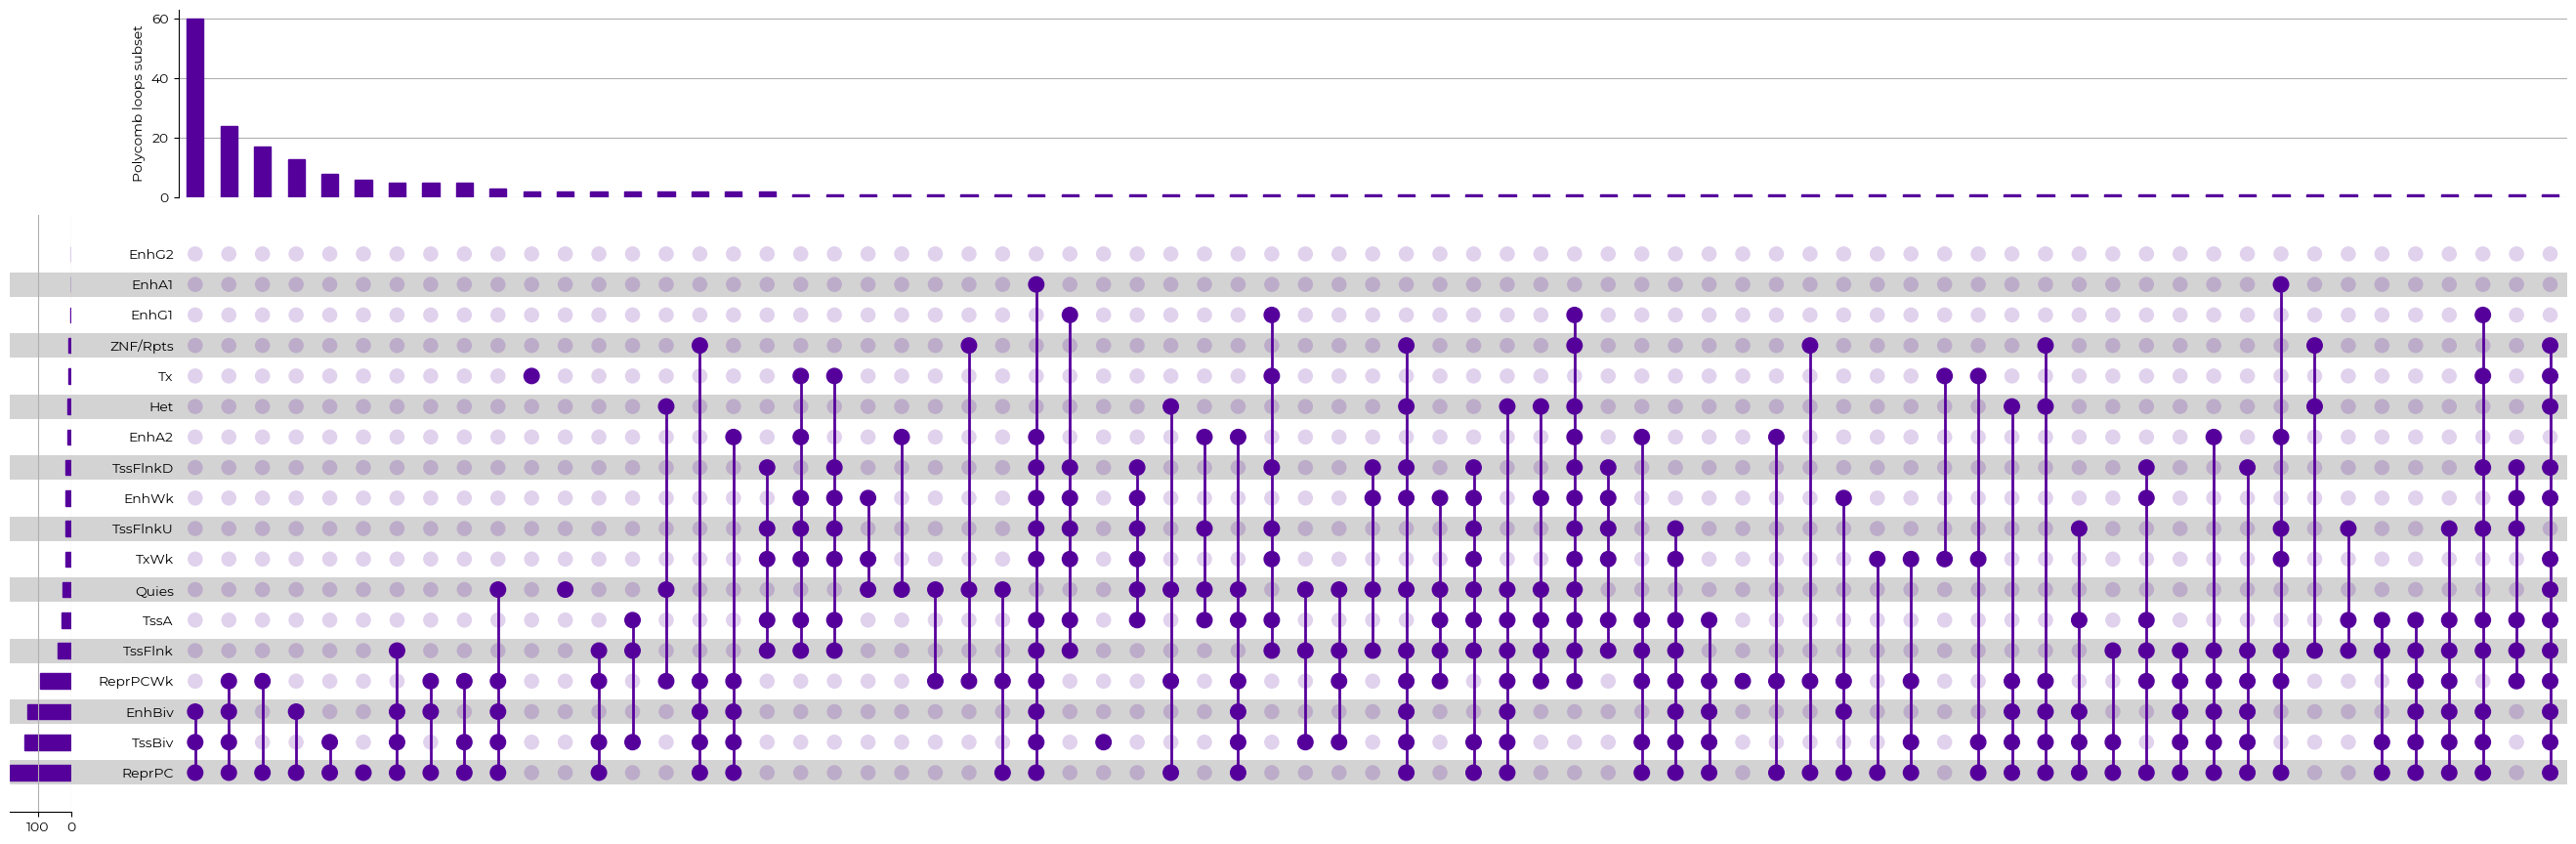

In [18]:
# Plot all ChromHMM states
ax_dict = upsetplot.UpSet(polycomb_anchors_annohmm[annotypes + ['chrom', 'start', 'end']].groupby(annotypes).size(),
                          sort_by="cardinality", 
                          facecolor="#56009c", 
                          shading_color="lightgray"
                         ).plot()

ax_dict["intersections"].set_ylabel("Polycomb loops subset");

# 03: Polycomb loops characteristics

**Figures in thesis:**
- `Figure 4`: (I) Distribution of Polycomb loop lengths, (II) Polycomb loop intensities, (III) Average loop
- `Figure 5`: (IV) Intra- and inter-individual unique Polycomb loops

In [19]:
pcg_loops = pd.read_csv('data/polycomb_loops.tsv', sep='\t')

pcg_loops['dist_from_diag_mbp'] = pcg_loops['dist_from_diag']/1e6
pcg_loops['value_log2'] = np.log2(pcg_loops['value']+1)
pcg_loops['contact_pair'] = tuple(zip(pcg_loops.region1, pcg_loops.region2))

pcg_loops['Celltype'] = pcg_loops['Celltype'].astype('category')
pcg_loops['Celltype']= pcg_loops['Celltype'].cat.reorder_categories(['NeuN+', 'NeuN-'])

### _03 (I) Distribution of Polycomb loop lengths

Text(0.5, 0, 'Polycomb loop length, Mbp')

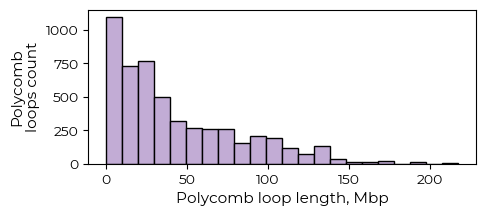

In [20]:
fig = plt.figure(figsize=(5, 2), dpi=100)

sns.histplot(pcg_loops, x='dist_from_diag_mbp', 
             binwidth=10, linewidth=1, 
             edgecolor="black", facecolor='#c2acd5'
           )
plt.ylabel('Polycomb\nloops count', fontsize=11)
plt.xlabel('Polycomb loop length, Mbp', fontsize=11)

### _03 (II) Polycomb loop intensities

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


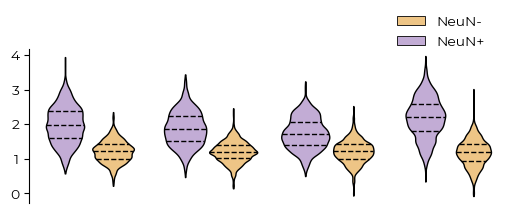

In [21]:
fig= plt.figure(figsize=(6.2, 2), dpi=100)

my_pal = {"NeuN+": "#c3a5dc", "NeuN-": "#ffc875"} 

ax = sns.violinplot(pcg_loops, 
                    x='Patient', y='value_log2', 
                    hue='Celltype', palette=my_pal, 
                    bw=.2, cut=1, linewidth=1, inner="quartile");

for l in ax.lines:
    l.set_linestyle('--')
    l.set_linewidth(1)
    l.set_color('black')
plt.setp(ax.collections, edgecolor="k")

plt.ylabel('')
ax.xaxis.set_visible(False)
for spine in plt.gca().spines:
    if spine != 'left':
        plt.gca().spines[spine].set_visible(False)
    

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
for i in order:
    handles[i].set(edgecolor='black', linewidth=0.6)
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
           frameon=False, loc="upper left", bbox_to_anchor=(0.74,1.3));


### _03 (III) Average loop

In [22]:
RES = 10000

patients = ('3M', '91', '318', '2M')
clr_dir = os.path.join('../../wd/data')
clr_names = {'3M_NeuN-': "HC-3Mminus.mcool",
             '3M_NeuN+': "HC-3Mplus.mcool",
             '91_NeuN-': "HC-91minus.mcool",
             '91_NeuN+': "HC-91plus.mcool",
             '318_NeuN+': "HC-318plus.mcool",
             '318_NeuN-': "HC-318minus.mcool",
             '2M_NeuN-': "HC-2Mminus.mcool",
             '2M_NeuN+': "HC-2Mplus.mcool"
            }
clrs = {samp: cooler.Cooler(os.path.join(clr_dir, clr_names[samp]) + f'::resolutions/{RES}') 
        for samp in clr_names.keys()}

chroms_view = pd.DataFrame(data={
'chrom': clrs['3M_NeuN-'].chromsizes.index,
'start': [0] * len(clrs['3M_NeuN-'].chromsizes),
'end': clrs['3M_NeuN-'].chromsizes.values,
'name': clrs['3M_NeuN-'].chromsizes.index
})

In [23]:
# Calculate excpected Hi-C map for all individuals
cvd = {}
for sample in tqdm(clrs.keys()):
    cvd[sample] = cooltools.expected_cis(
        clrs[sample],
        view_df=chroms_view,
        smooth=False,
        nproc=6
    )

100%|██████████| 8/8 [01:40<00:00, 12.53s/it]


In [24]:
# Calculate pileups (average features)
pileups = {}
pileups_agg = {}
for sample in tqdm(clrs.keys()):
    stack = cooltools.pileup(clrs[sample], pcg_loops, 
                         view_df=chroms_view, 
                         expected_df=cvd[sample], 
                         nproc=6,
                         flank=200000)
    pileups[sample] = stack
    pileups_agg[sample] = np.nanmean(stack, axis=2)

100%|██████████| 8/8 [00:35<00:00,  4.39s/it]


Text(0, 0.5, '')

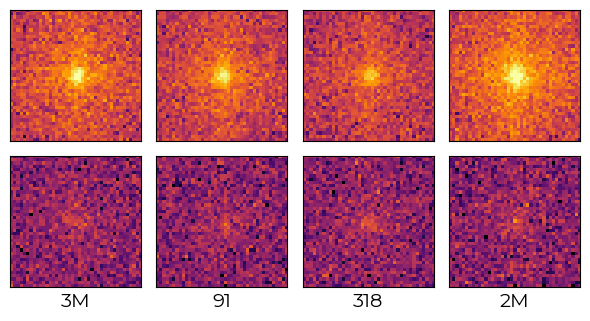

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=4, 
                        figsize=(6, 3.4), dpi=100, 
                        layout='tight', 
                        sharey=True, sharex=True)

borders = []
for sample in clrs.keys():
    mtx = pileups_agg[sample]
    data = np.log2(mtx)[np.isfinite(np.log2(mtx))]
    max_, min_ = np.abs(np.max(data)), np.abs(np.min(data))
    border = np.ceil(np.max([max_, min_]))
    borders.append(border)
border = np.max(border)

for i, patient in enumerate(patients):
    for j, ct in enumerate(('_NeuN+', '_NeuN-')):
        sample = patient + ct
        
        axs[j,i].imshow(
                        np.log2(pileups_agg[sample]),
                        vmax = border-1,
                        vmin = -border+3,
                        cmap = 'inferno')
        axs[j,i].set_xticks([])
        axs[j,i].set_yticks([])
        if j == 1:
            axs[j,i].set_xlabel(patient, size=14)
plt.ylabel('')


### _03 (IV) Intra- and inter-individual unique Polycomb loops

In [27]:
top_n = 15

smallest_polycombs = pd.DataFrame(columns=['Peaks', 'N_Peaks'])
largest_polycombs = pd.DataFrame(columns=['Peaks', 'N_Peaks'])
for i in range(1, top_n):
    # Get top_n smallest peaks
    smallest_peaks = set(pcg_loops.query('Celltype=="NeuN+"')\
                                  .set_index('contact_pair')\
                                  .groupby('Patient')\
                                  .value.nsmallest(i)\
                                  .reset_index().contact_pair)
    smallest_polycombs.loc[i, 'Peaks'] = smallest_peaks
    smallest_polycombs.loc[i, 'N_Peaks'] = len(smallest_peaks)

    # Get top_n largest peaks
    largest_peaks = set(pcg_loops.query('Celltype=="NeuN+"')\
                                 .set_index('contact_pair')\
                                 .groupby('Patient')\
                                 .value.nlargest(i)\
                                 .reset_index().contact_pair)
    largest_polycombs.loc[i, 'Peaks'] = largest_peaks
    largest_polycombs.loc[i, 'N_Peaks'] = len(largest_peaks)
    
top_polycombs = pd.concat([smallest_polycombs, largest_polycombs], keys=['smallest', 'largest'], names=['Top', 'N']).reset_index()

Text(0.02, 0.5, 'N unique peaks in total')

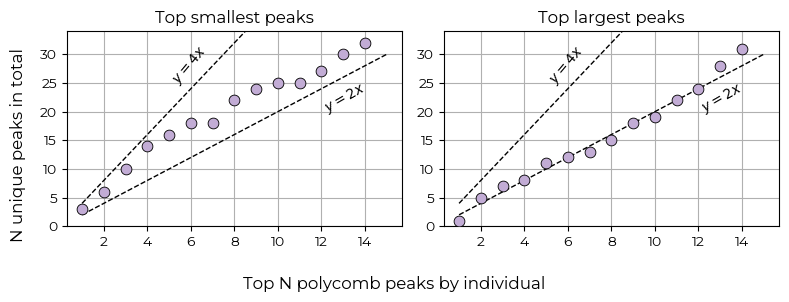

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=2, 
                        figsize=(8, 3), dpi=100,
                        layout='tight')

for i, top in enumerate(['smallest', 'largest']):
    sns.scatterplot(top_polycombs.query('Top==@top'), y='N_Peaks', x='N',
                    edgecolor='black', s=60, ax=axs[i], color='#c2acd5', zorder=999)

    axs[i].set(xlabel=None, ylabel=None)
    
    x = np.linspace(1, top_n)
    axs[i].plot(x,4*x, color='black', linewidth=1, linestyle='--')
    axs[i].plot(x,2*x, color='black', linewidth=1, linestyle='--')
    axs[i].text(5, 25, '$y=4x$', rotation=50)
    axs[i].text(12, 20, '$y=2x$', rotation=30)
    
    axs[i].set_ylim((0, 34))
    axs[i].grid()
    axs[i].set_title(f'Top {top} peaks')
    

fig.supxlabel('Top N polycomb peaks by individual')
fig.supylabel('N unique peaks in total')